<a href="https://colab.research.google.com/github/bpavie/python_segmentation_notebooks/blob/main/segment_anything_cell_test_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-u_waujd0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-u_waujd0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=e6f74061fe4fca89fc969c712a2ec6eca4e0fa0a42ca4bc603e81205e361fd5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-lb3v_j_q/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segm

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [6]:
image = cv2.imread('/content/drive/MyDrive/hela_green_RGB.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

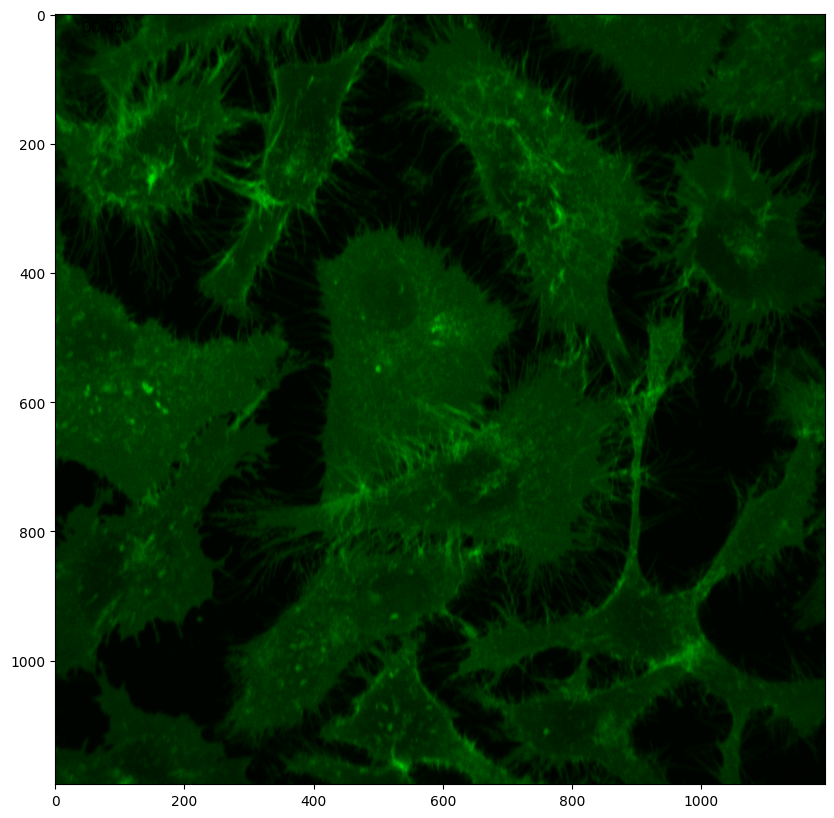

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [9]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [30]:
input_point = np.array([[370, 200], [300, 200]])
input_label = np.array([1, 0])

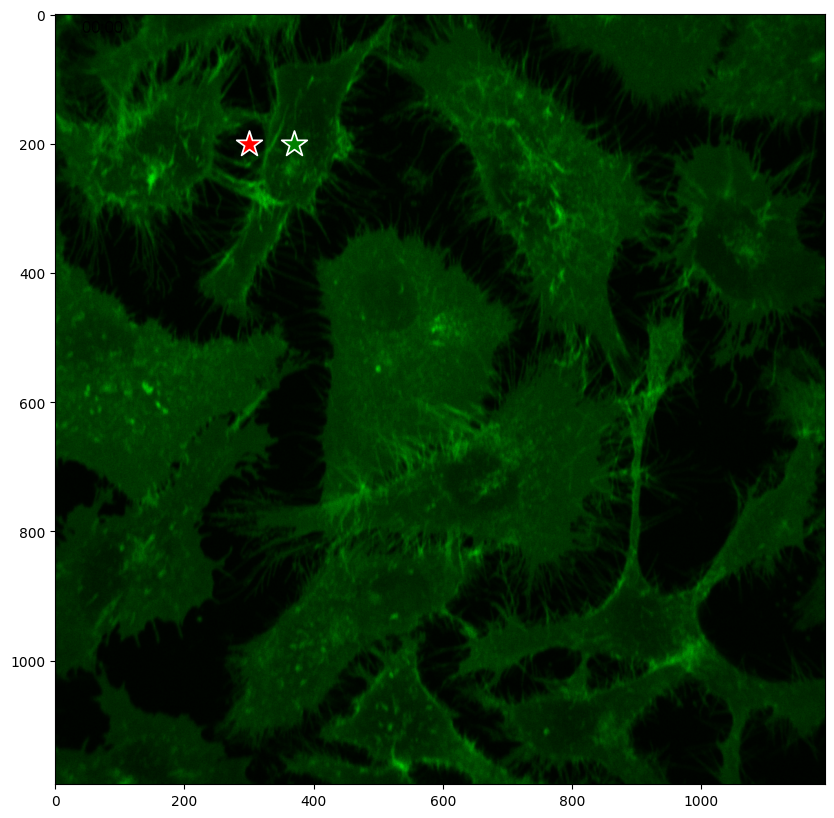

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [17]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [18]:
masks.shape  # (number_of_masks) x H x W

(3, 1192, 1192)

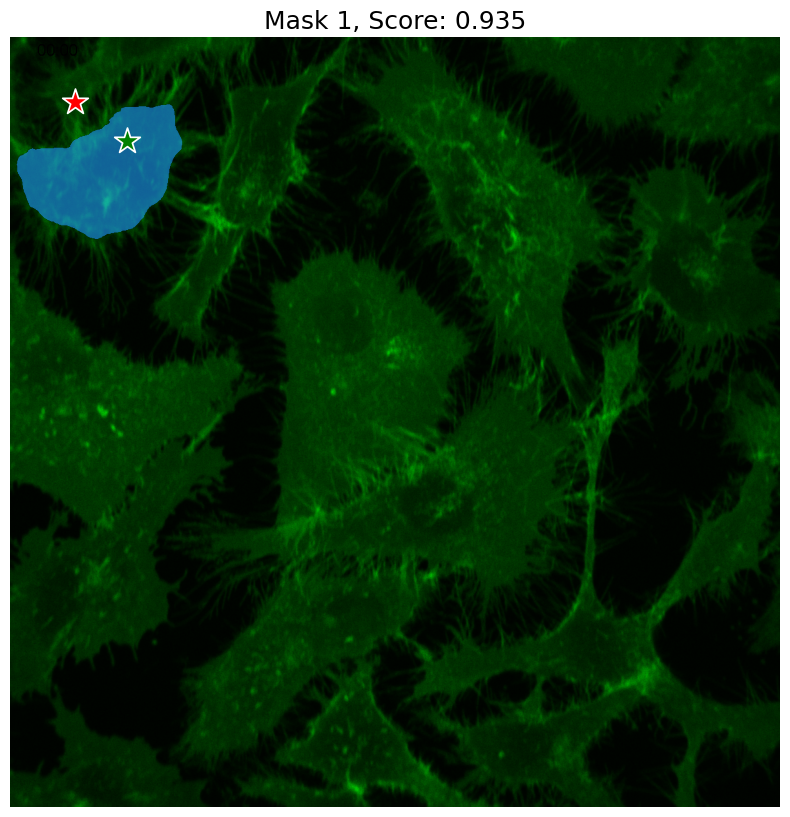

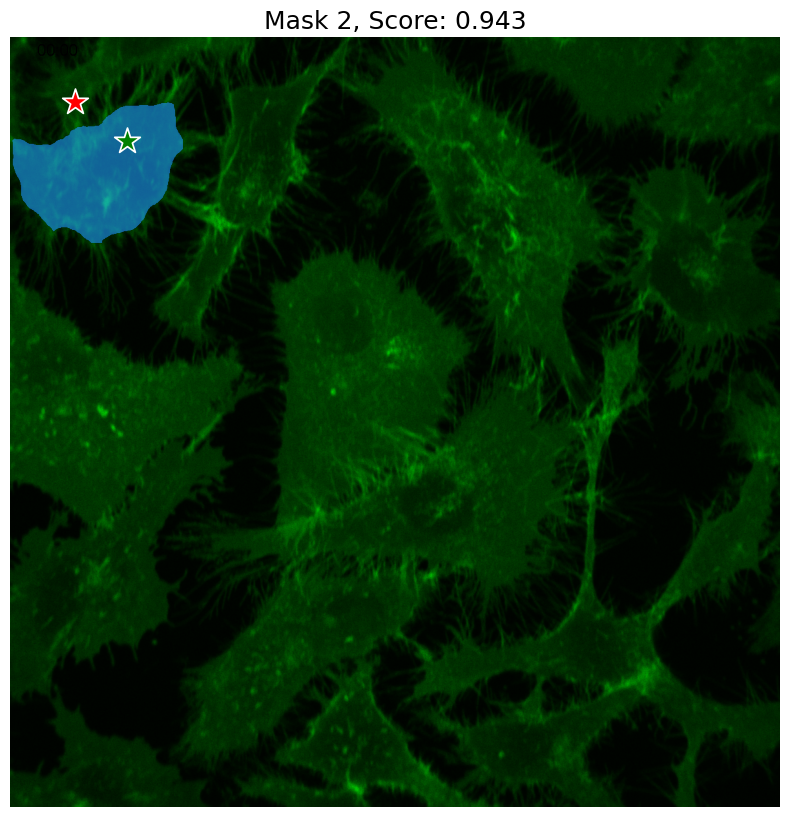

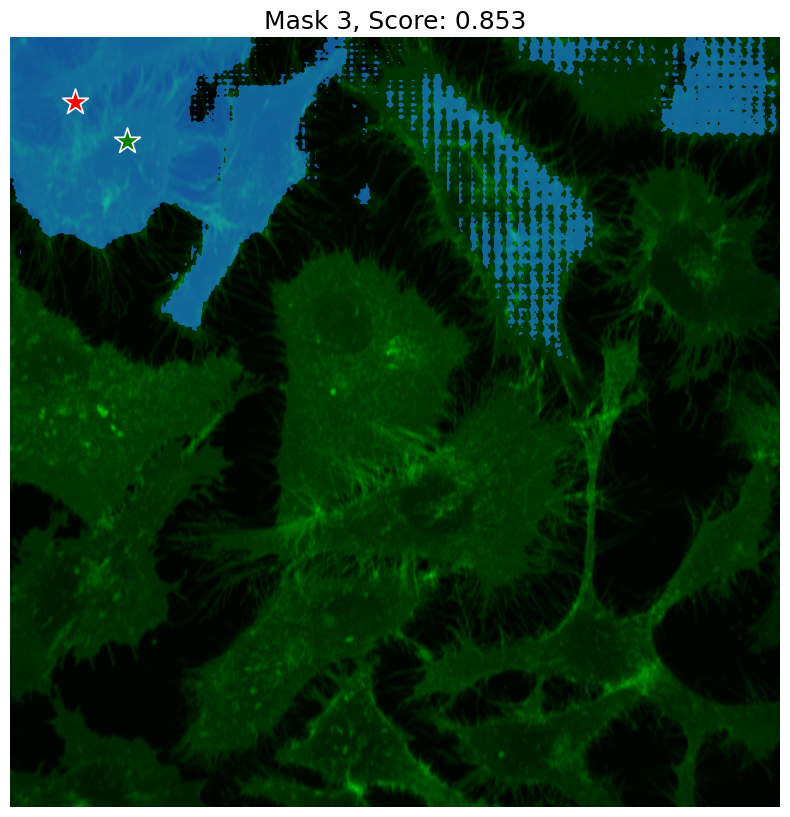

In [19]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

## Apply multiple points

Positive point only

In [53]:
input_points = torch.tensor([
    [[162, 204]],
    [[395, 181]],
    [[713, 265]],
    [[1031, 391]],
    [[507, 433]],
    [[61, 511]],
    [[655, 727]],
    [[513, 903]],
    [[911, 943]],
    [[801, 1103]],
    [[523, 1097]],
    [[77, 859]],
    [[133, 1167]],
    [[507, 1187]],
    [[205, 5]]
], device=predictor.device)
input_labels = torch.tensor([
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
], device=predictor.device)

In [55]:
transformed_points = predictor.transform.apply_coords_torch(input_points, image.shape[:2])
transformed_labels = input_labels.to(torch.float)
masks, _, _ = predictor.predict_torch(
    point_coords=transformed_points,
    point_labels=transformed_labels,
    boxes=None,
    multimask_output=False,
)

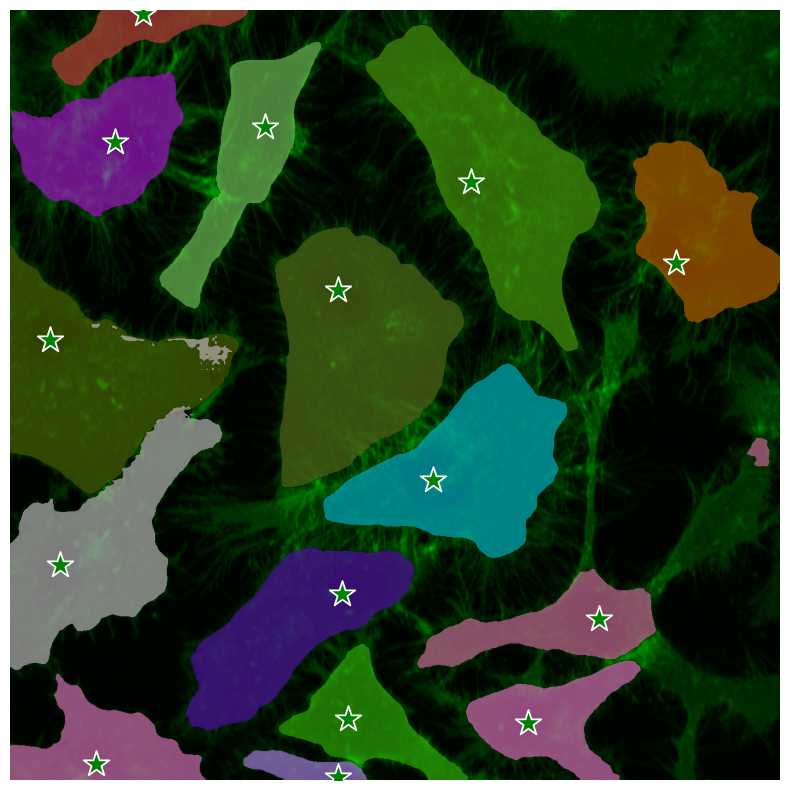

In [56]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
show_points(input_points.cpu().numpy(), input_labels.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

Point positive and negative label

In [68]:
input_points = torch.tensor([
    [[162, 204], [260, 204]],
    [[395, 181], [313, 190]],
    [[713, 265], [641, 259]],
    [[1031, 391], [947, 401]],
    [[507, 433], [545, 329]],
    [[61, 511], [135, 429]],
    [[655, 727], [709, 553]],
    [[513, 903], [637, 909]],
    [[911, 943], [947, 871]],
    [[801, 1103], [695, 1123]],
    [[523, 1097], [449, 1071]],
    [[77, 859], [91, 759]],
    [[133, 1167], [163, 1069]],
    [[507, 1187], [575, 1185]],
    [[205, 5], [191, 67]]
], device=predictor.device)
input_labels = torch.tensor([
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
    [1,0],
], device=predictor.device)

#input_points = torch.tensor([
#    [[162, 204], [100, 100]],
#    [[370, 200], [300, 200]],
#], device=predictor.device)
#input_labels = torch.tensor([
#    [1,0],
#    [1,0],
#], device=predictor.device)


## Transform the tensor to numpy to plot them 



In [69]:
transformed_points = predictor.transform.apply_coords_torch(input_points, image.shape[:2])
transformed_labels = input_labels.to(torch.float)
masks, _, _ = predictor.predict_torch(
    point_coords=transformed_points,
    point_labels=transformed_labels,
    boxes=None,
    multimask_output=False,
)

In [70]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([15, 1, 1192, 1192])

## Plot the segmentation result

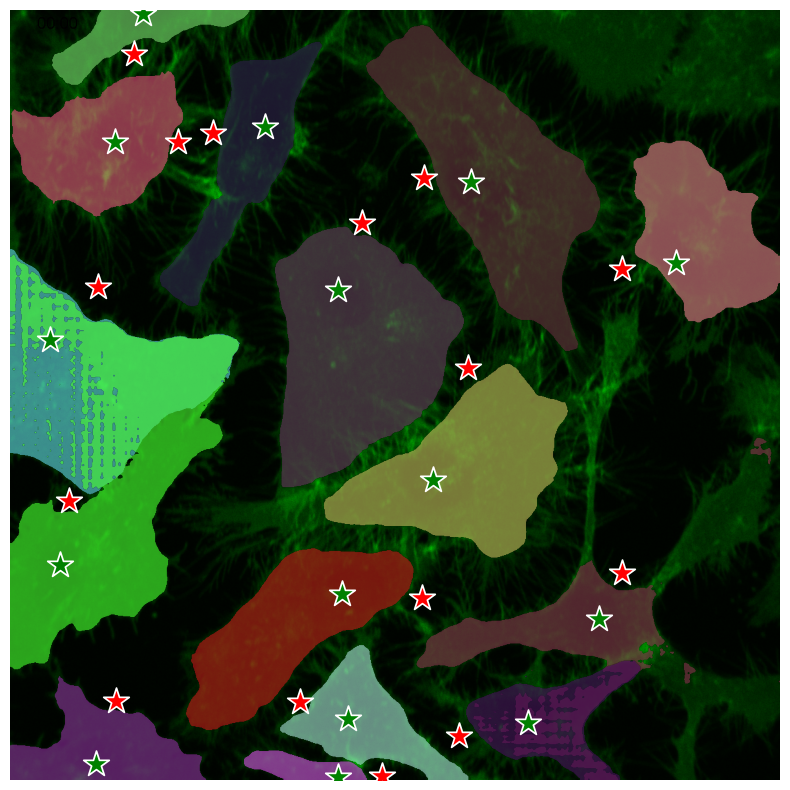

In [71]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
show_points(input_points.cpu().numpy(), input_labels.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()